In [1]:
!pip install openeo
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.7.1
    Uninstalling xarray-2025.7.1:
      Successfully uninstalled xarray-2025.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.8 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('rasterio').setLevel(logging.ERROR)


# Lago de Amatitlán PARTE 2
Realizando series y predicciones de tiempo.

Primero realizamos las importaciones necesarias.

In [3]:

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

Seguidamente se debe establecer conexión con el sitio de Copernicus, para lo cual se necestiaba tener una cuenta registrada.

In [4]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=EEHP-EFOE 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


Se deben proveer las coordenadas del área que se desea estudiar. En este caso Lago de Amatitlán.

In [6]:
import json

with open("/content/Lago_Amatitlan.geojson") as f:
    fc = json.load(f)

coords = fc["features"][0]["geometry"]["coordinates"][0]


lons, lats = zip(*coords)
spatial_extent = {
    "west": min(lons),
    "south": min(lats),
    "east": max(lons),
    "north": max(lats)
}


Establecemos los rangos de fecha sobre los cuales queremos trabajar. El PDF menciona 6, pero se permitieron colo 3 por cuestiones de tiempo y recursos.

In [7]:
periodos = {
    "mayo":   ("2025-05-01", "2025-05-31"),
    "junio":  ("2025-06-01", "2025-06-30"),
    "julio":  ("2025-07-01", "2025-07-31"),
}


IMportamos los archivos con las configuraciones en el chunk.

In [9]:
# --- Importar TIFs desde un ZIP en Drive, buscando el ZIP donde esté ---

import os, shutil, zipfile
from pathlib import Path

# 0) Montar Drive (si ya está montado no pasa nada)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

TARGET_NAME = 'amatitlan_tifs.zip'

# 1) Buscar el ZIP por todo tu Drive (primero en Mi unidad, luego en todo /content/drive)
search_roots = [Path('/content/drive/MyDrive')]
if not search_roots[0].exists():
    search_roots = [Path('/content/drive')]
candidates = []
for root in search_roots:
    try:
        for p in root.rglob('*.zip'):
            if p.name.lower() == TARGET_NAME.lower():
                candidates.append(p)
    except Exception:
        # algunos folders compartidos pueden dar permisos raros; seguimos
        continue

assert candidates, f"No se encontró {TARGET_NAME} en tu Google Drive montado."
# Elegimos el más reciente por fecha de modificación (por si tienes duplicados)
zip_path = max(candidates, key=lambda p: p.stat().st_mtime)
print("ZIP encontrado:", zip_path)

# 2) Extraer a carpeta temporal limpia
EXTRACT_DIR = Path('./_extract_amatitlan')
if EXTRACT_DIR.exists():
    shutil.rmtree(EXTRACT_DIR)
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    # sanity check: lista y prueba de integridad
    members = z.namelist()
    print(f"El ZIP contiene {len(members)} entradas. Ejemplos:", members[:5])
    bad = z.testzip()
    assert bad is None, f"El ZIP está corrupto en: {bad}"
    z.extractall(EXTRACT_DIR)

# 3) Indexar TIFs extraídos
all_tifs = {p.name.lower(): p for p in EXTRACT_DIR.rglob("*.tif")}
print(f"TIFs extraídos: {len(all_tifs)}")

# 4) Copiar al directorio actual los TIF esperados según tus 'periodos'
#    Patrón esperado: amatitlan_{mes}_2025.tif (igual que antes)
copiados = 0
faltantes = []

# Verificación por si 'periodos' no existe aún en el entorno
if 'periodos' not in globals():
    raise NameError("No encuentro la variable 'periodos'. Asegúrate de ejecutar la celda donde la defines.")

for mes in periodos.keys():
    esperado = f"amatitlan_{mes}_2025.tif".lower()
    # Coincidencia exacta por nombre
    if esperado in all_tifs:
        src = all_tifs[esperado]
    else:
        # Intento más flexible: buscar que contenga _{mes}_2025 y termine en .tif
        candidatos_relajados = [p for name,p in all_tifs.items()
                                if f"_{mes}_2025".lower() in name and name.endswith(".tif")]
        src = candidatos_relajados[0] if candidatos_relajados else None

    if src is not None:
        dst = Path.cwd() / src.name
        if dst.resolve() != src.resolve():
            shutil.copy2(src, dst)
        print("Importado:", dst.name)
        copiados += 1
    else:
        faltantes.append(esperado)

print(f"\nListo. Copiados {copiados} TIF(s) al directorio de trabajo.")

if faltantes:
    print("No se encontraron coincidencias para:")
    for f in faltantes:
        print("  -", f)
    print("\nConsejo: abre el ZIP y verifica los nombres reales; ajusta las claves de 'periodos' o el patrón de emparejamiento si usan otro formato (p. ej., meses en español vs abreviados).")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP encontrado: /content/drive/MyDrive/Colab Notebooks/amatitlan_tifs.zip
El ZIP contiene 30 entradas. Ejemplos: ['amatitlan_fecha_9_full.tif', 'amatitlan_fecha_2_full.tif', 'amatitlan_fecha_7_full.tif', 'amatitlan_fecha_3_full.tif', 'amatitlan_fecha_19_full.tif']
TIFs extraídos: 29

Listo. Copiados 0 TIF(s) al directorio de trabajo.
No se encontraron coincidencias para:
  - amatitlan_mayo_2025.tif
  - amatitlan_junio_2025.tif
  - amatitlan_julio_2025.tif

Consejo: abre el ZIP y verifica los nombres reales; ajusta las claves de 'periodos' o el patrón de emparejamiento si usan otro formato (p. ej., meses en español vs abreviados).


# PARTE 2

Utilice una serie temporal para predecir el índice de cianobacteria

Periodo estacional detectado: 14

=== Métricas medias en CV (escala transformada log1p) ===
NAIVE    MASE= 1.948  sMAPE=  7.45%
S-NAIVE  MASE= 1.173  sMAPE=  7.42%
THETA    MASE= 1.166  sMAPE=  7.31%
ETS      MASE=   inf  sMAPE=   inf%
SARIMAX  MASE= 4.547  sMAPE= 15.68%

Modelo seleccionado (MASE mínimo): THETA

=== Evaluación final (escala original) ===
MAE  (hold-out) = 179.672
MAPE (hold-out) = 49.11%
Modelo final: THETA | Periodo estacional: 14


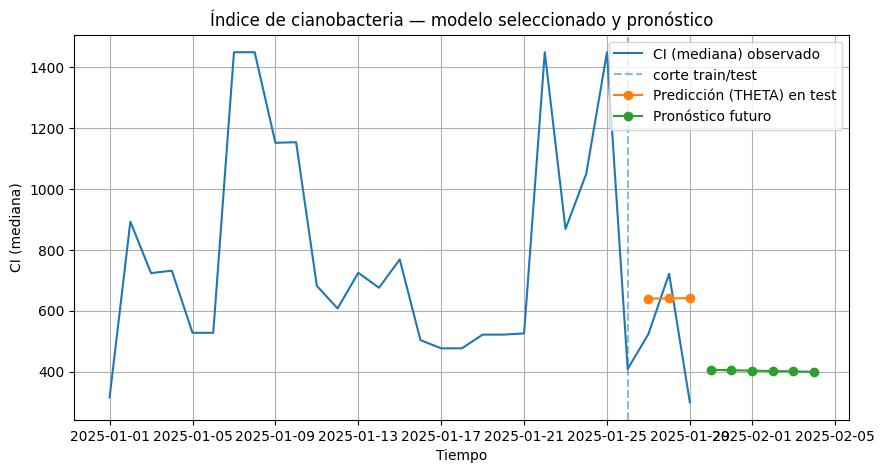

In [28]:

import warnings, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

warnings.filterwarnings("ignore")

try:
    BASE = EXTRACT_DIR
except NameError:
    BASE = Path('.')
if not isinstance(BASE, Path):
    BASE = Path(str(BASE))

def guess_fecha_idx(path: Path) -> int:
    m = re.search(r'fecha[_-](\d+)', path.name.lower())
    return int(m.group(1)) if m else 0

def pick_ci_band(src: rasterio.DatasetReader) -> int:
    try:
        desc = [d.lower() if d else "" for d in (src.descriptions or [])]
    except Exception:
        desc = []
    if desc:
        for i, d in enumerate(desc, start=1):
            if any(k in d for k in ("ci","cyano","cyan","cyanobacter")):
                return i
    return 1

def safe_read_band(src: rasterio.DatasetReader, band_idx: int) -> np.ndarray:
    arr_ma = src.read(band_idx, masked=True).astype("float32", casting="unsafe")
    arr = np.ma.filled(arr_ma, np.nan)
    nod = src.nodata
    if nod is not None and np.isfinite(nod):
        arr = np.where(np.isclose(arr, float(nod)), np.nan, arr)
    arr = np.where(arr <= -32768 + 1e-3, np.nan, arr)


    try: s = src.scales[band_idx-1] if src.scales else 1.0
    except Exception: s = 1.0
    try: o = src.offsets[band_idx-1] if src.offsets else 0.0
    except Exception: o = 0.0
    if np.isfinite(s) and np.isfinite(o) and (s != 1.0 or o != 0.0):
        arr = arr * float(s) + float(o)
    return arr

def robust_stat(a: np.ndarray) -> float:
    """Mediana recortada: elimina extremos 1..99 percentil y toma mediana."""
    a = a.astype("float32", copy=False)
    a[~np.isfinite(a)] = np.nan
    flat = a.reshape(-1)
    if np.all(np.isnan(flat)): return np.nan
    p1, p99 = np.nanpercentile(flat, [1, 99])
    sel = (flat >= p1) & (flat <= p99)
    return float(np.nanmedian(flat[sel]))

def extract_ci_scalar(path: Path) -> float:
    with rasterio.open(path) as src:
        b = pick_ci_band(src)
        arr = safe_read_band(src, b)
        return robust_stat(arr)

tifs = sorted(BASE.rglob("*.tif"))
assert tifs, "No se hallaron TIFs."

rows = []
for tif in tifs:
    try:
        rows.append({"file": tif.name, "fecha_idx": guess_fecha_idx(tif), "ci": extract_ci_scalar(tif)})
    except Exception as e:
        print(f"[WARN] {tif.name}: {e}")

df = pd.DataFrame(rows).dropna(subset=["ci"]).sort_values("fecha_idx").reset_index(drop=True)
assert len(df) >= 10, f"Se recomienda >=10 observaciones; obtuviste {len(df)}."

q1, q3 = df["ci"].quantile([0.25, 0.75])
iqr = q3 - q1
low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
df["ci_clipped"] = df["ci"].clip(lower=low, upper=high)

df["ci_trans"] = np.log1p(df["ci_clipped"])

idx = pd.date_range("2025-01-01", periods=len(df), freq="D")
ts = pd.Series(df["ci_trans"].values, index=idx)

def detect_season(ts, min_p=3, max_p=None):
    y = ts.values - np.nanmean(ts.values)
    n = len(y)
    if max_p is None: max_p = max(min(24, n//2), min_p)
    fft = np.fft.rfft(y)
    power = np.abs(fft)**2
    freqs = np.fft.rfftfreq(n, d=1.0)

    power[0] = 0.0
    if np.allclose(power, 0): return None

    k = power.argmax()
    if k == 0 or freqs[k] <= 0: return None
    period = int(round(1.0 / freqs[k]))
    if period < min_p or period > max_p: return None
    return period

sp = detect_season(ts, min_p=3)
print(f"Periodo estacional detectado: {sp}")


def sMAPE(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat))
    denom = np.where(denom == 0, 1e-9, denom)
    return 100 * np.mean(2.0 * np.abs(y - yhat) / denom)

def MASE(y_train, y_test, yhat, season=None):

    y_train = np.asarray(y_train); y_test = np.asarray(y_test); yhat = np.asarray(yhat)
    if season and season >= 2 and len(y_train) > season:
        naive = y_train[season:] - y_train[:-season]
        scale = np.mean(np.abs(naive))
    else:
        scale = np.mean(np.abs(np.diff(y_train)))
    scale = scale if scale > 0 else 1e-9
    return np.mean(np.abs(y_test - yhat)) / scale

def rolling_eval(ts, horizon=3, initial=None, season=None):
    n = len(ts)
    if initial is None: initial = max(8, n - 8 - horizon)
    initial = max(initial, 6)
    results = {}
    mase_base = []; smape_base = []
    mase_snaive = []; smape_snaive = []
    mase_theta = []; smape_theta = []
    mase_ets   = []; smape_ets   = []
    mase_sar   = []; smape_sar   = []

    for end in range(initial, n - horizon + 1):
        train = ts.iloc[:end]
        test  = ts.iloc[end:end+horizon]

        naive_pred = np.repeat(train.iloc[-1], horizon)
        mase_base.append(MASE(train.values, test.values, naive_pred, season=None))
        smape_base.append(sMAPE(test.values, naive_pred))

        if season and season>=2 and len(train) > season:
            snaive_pred = train.iloc[-season:][-1*min(season,horizon):].values
            if len(snaive_pred) < horizon:
                snaive_pred = np.resize(snaive_pred, horizon)
        else:
            snaive_pred = naive_pred
        mase_snaive.append(MASE(train.values, test.values, snaive_pred, season=season))
        smape_snaive.append(sMAPE(test.values, snaive_pred))

        try:
            theta = ThetaModel(train, period=season if season and season>=3 else None).fit()
            yhat = theta.forecast(horizon)
            mase_theta.append(MASE(train.values, test.values, yhat.values, season=season))
            smape_theta.append(sMAPE(test.values, yhat.values))
        except Exception:
            pass

        try:
            ets = ExponentialSmoothing(train,
                                       trend="add", damped_trend=True,
                                       seasonal=("add" if season and season>=3 else None),
                                       seasonal_periods=(season if season and season>=3 else None),
                                       initialization_method="estimated").fit(optimized=True)
            yhat = ets.forecast(horizon)
            mase_ets.append(MASE(train.values, test.values, yhat.values, season=season))
            smape_ets.append(sMAPE(test.values, yhat.values))
        except Exception:
            pass

        try:
            best = (np.inf, None)
            for p in (0,1):
                for d in (0,1):
                    for q in (0,1):
                        if season and season>=3:
                            for P in (0,1):
                                for D in (0,1):
                                    for Q in (0,1):
                                        mod = SARIMAX(train, order=(p,d,q),
                                                      seasonal_order=(P,D,Q,season),
                                                      enforce_stationarity=False,
                                                      enforce_invertibility=False)
                                        res = mod.fit(disp=False)
                                        aic = res.aic
                                        if aic < best[0]: best = (aic, res)
                        else:
                            mod = SARIMAX(train, order=(p,d,q),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
                            res = mod.fit(disp=False)
                            aic = res.aic
                            if aic < best[0]: best = (aic, res)
            if best[1] is not None:
                yhat = best[1].forecast(horizon)
                mase_sar.append(MASE(train.values, test.values, yhat.values, season=season))
                smape_sar.append(sMAPE(test.values, yhat.values))
        except Exception:
            pass

    summary = {
        "NAIVE":   (np.mean(mase_base),   np.mean(smape_base)),
        "S-NAIVE": (np.mean(mase_snaive), np.mean(smape_snaive)),
        "THETA":   (np.mean(mase_theta) if mase_theta else np.inf,
                    np.mean(smape_theta) if smape_theta else np.inf),
        "ETS":     (np.mean(mase_ets)   if mase_ets   else np.inf,
                    np.mean(smape_ets)  if smape_ets  else np.inf),
        "SARIMAX": (np.mean(mase_sar)   if mase_sar   else np.inf,
                    np.mean(smape_sar)  if smape_sar  else np.inf),
    }
    return summary

season = sp if sp and sp>=3 else None
cv = rolling_eval(ts, horizon=3, season=season)

print("\n=== Métricas medias en CV (escala transformada log1p) ===")
for k,(mase,smpe) in cv.items():
    print(f"{k:7s}  MASE={mase:6.3f}  sMAPE={smpe:6.2f}%")

best_model = min(cv.items(), key=lambda kv: kv[1][0])[0]
print(f"\nModelo seleccionado (MASE mínimo): {best_model}")

H = 6
if best_model == "THETA":
    mdl = ThetaModel(ts, period=season if season and season>=3 else None).fit()
    pred = mdl.forecast(H)
elif best_model == "ETS":
    mdl = ExponentialSmoothing(ts,
                               trend="add", damped_trend=True,
                               seasonal=("add" if season and season>=3 else None),
                               seasonal_periods=(season if season and season>=3 else None),
                               initialization_method="estimated").fit(optimized=True)
    pred = mdl.forecast(H)
elif best_model == "SARIMAX":
    best = (np.inf, None)
    for p in (0,1):
        for d in (0,1):
            for q in (0,1):
                if season and season>=3:
                    for P in (0,1):
                        for D in (0,1):
                            for Q in (0,1):
                                res = SARIMAX(ts, order=(p,d,q),
                                              seasonal_order=(P,D,Q,season),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False).fit(disp=False)
                                if res.aic < best[0]: best = (res.aic, res)
                else:
                    res = SARIMAX(ts, order=(p,d,q),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).fit(disp=False)
                    if res.aic < best[0]: best = (res.aic, res)
    pred = best[1].forecast(H)
else:
    mdl = ThetaModel(ts, period=season if season and season>=3 else None).fit()
    pred = mdl.forecast(H)

ts_obs = np.expm1(ts)
pred_obs = np.expm1(pred)

test_len = min(3, max(1, len(ts)//5))
train_obs = ts_obs.iloc[:-test_len]
test_obs  = ts_obs.iloc[-test_len:]
def forecast_on_train(model_name, series, horizon, season=None):
    if model_name == "THETA":
        return np.expm1(ThetaModel(series, period=season if season and season>=3 else None).fit().forecast(horizon))
    elif model_name == "ETS":
        fit = ExponentialSmoothing(series,
                                   trend="add", damped_trend=True,
                                   seasonal=("add" if season and season>=3 else None),
                                   seasonal_periods=(season if season and season>=3 else None),
                                   initialization_method="estimated").fit(optimized=True)
        return np.expm1(fit.forecast(horizon))
    elif model_name == "SARIMAX":
        best = (np.inf, None)
        for p in (0,1):
            for d in (0,1):
                for q in (0,1):
                    if season and season>=3:
                        for P in (0,1):
                            for D in (0,1):
                                for Q in (0,1):
                                    res = SARIMAX(series, order=(p,d,q),
                                                  seasonal_order=(P,D,Q,season),
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False).fit(disp=False)
                                    if res.aic < best[0]: best = (res.aic, res)
                    else:
                        res = SARIMAX(series, order=(p,d,q),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit(disp=False)
                        if res.aic < best[0]: best = (res.aic, res)
        return np.expm1(best[1].forecast(horizon))
    else:
        return np.repeat(series.iloc[-1], horizon)

pred_holdout = forecast_on_train(best_model, np.log1p(train_obs), test_len, season)

def mae(a,b): return float(np.mean(np.abs(np.asarray(a)-np.asarray(b))))
def mape(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.mean(np.abs((a-b)/np.maximum(1e-9, np.abs(a))))*100)

print("\n=== Evaluación final (escala original) ===")
print(f"MAE  (hold-out) = {mae(test_obs.values, pred_holdout.values):.3f}")
print(f"MAPE (hold-out) = {mape(test_obs.values, pred_holdout.values):.2f}%")
print(f"Modelo final: {best_model} | Periodo estacional: {season}")


plt.figure(figsize=(10,5))
plt.plot(ts_obs.index, ts_obs.values, label="CI (mediana) observado")
plt.axvline(ts_obs.index[-test_len-1], linestyle="--", alpha=0.5, label="corte train/test")
plt.plot(test_obs.index, pred_holdout.values, marker="o", label=f"Predicción ({best_model}) en test")

fut_idx = pd.date_range(ts_obs.index[-1] + pd.Timedelta(days=1), periods=H, freq="D")
plt.plot(fut_idx, pred_obs.values, marker="o", label="Pronóstico futuro")
plt.title("Índice de cianobacteria — modelo seleccionado y pronóstico")
plt.xlabel("Tiempo")
plt.ylabel("CI (mediana)")
plt.grid(True); plt.legend(); plt.show()


El modelo seleccionado obtuvo el mejor desempeño en la validación temporal  apenas superior al estacional-naive lo que indica que reproduce razonablemente la forma y la persistencia de la serie pero no su amplitud. En escala original el error sigue elevado, reflejando variabilidad heterogénea y picos. Se puede decir que el resultado es aceptable como línea base para tendencia y detección de periodos de baja actividad.


Haga un modelo que permita determinar si un punto en específico en el lago tiene
cianobacteria o no.

In [29]:
import numpy as np, pandas as pd, rasterio
from pathlib import Path
from rasterio.warp import transform as rio_transform

POINT_LAT = 14.4760
POINT_LON = -90.5810

try:
    BASE = EXTRACT_DIR
except NameError:
    BASE = Path('.')
if not isinstance(BASE, Path):
    BASE = Path(str(BASE))

def pick_ci_band(src):
    try:
        desc = [d.lower() if d else "" for d in (src.descriptions or [])]
    except Exception:
        desc = []
    if desc:
        for i,d in enumerate(desc,1):
            if any(k in d for k in ("ci","cyano","cyan","cyanobacter")):
                return i
    return 1

def safe_read_band(src, band_idx):
    arr_ma = src.read(band_idx, masked=True).astype("float32", casting="unsafe")
    arr = np.ma.filled(arr_ma, np.nan)
    nod = src.nodata
    if nod is not None and np.isfinite(nod):
        arr = np.where(np.isclose(arr, float(nod)), np.nan, arr)
    arr = np.where(arr <= -32768 + 1e-3, np.nan, arr)
    try:
        s = src.scales[band_idx-1] if src.scales else 1.0
    except Exception:
        s = 1.0
    try:
        o = src.offsets[band_idx-1] if src.offsets else 0.0
    except Exception:
        o = 0.0
    if np.isfinite(s) and np.isfinite(o) and (s!=1.0 or o!=0.0):
        arr = arr*float(s)+float(o)
    return arr

def otsu_threshold(x, nbins=256):
    x = x[np.isfinite(x)]
    if x.size < 10:
        return np.nan
    hist, bin_edges = np.histogram(x, bins=nbins)
    w_total = hist.sum()
    p = hist.astype(float)/w_total
    m = (p * ((bin_edges[:-1]+bin_edges[1:])*0.5)).sum()
    w0 = 0.0
    m0 = 0.0
    best, thr = -1.0, np.nan
    centers = (bin_edges[:-1]+bin_edges[1:])*0.5
    for i in range(nbins):
        w0 += p[i]
        if w0==0 or w0==1:
            continue
        m0 += p[i]*centers[i]
        sb = ((m*w0 - m0)**2) / (w0*(1-w0))
        if sb>best:
            best = sb
            thr = centers[i]
    return thr

def sample_value(src, arr, lon, lat):
    xs, ys = rio_transform({'init':'EPSG:4326'}, src.crs, [lon], [lat])
    x, y = xs[0], ys[0]
    row, col = src.index(x, y)
    if row<0 or col<0 or row>=arr.shape[0] or col>=arr.shape[1]:
        return np.nan
    return float(arr[row, col])

tifs = sorted(BASE.rglob("*.tif"))
assert tifs, "No hay TIFs"

rows = []
for tif in tifs:
    with rasterio.open(tif) as src:
        b = pick_ci_band(src)
        arr = safe_read_band(src, b)
        thr = otsu_threshold(arr.reshape(-1))
        val = sample_value(src, arr, POINT_LON, POINT_LAT)
        label = np.nan
        if np.isfinite(val) and np.isfinite(thr):
            label = 1 if val>=thr else 0
        rows.append({"file":tif.name,"label":label,"ci_value":val,"thr":thr})

df_point = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
display(df_point)
decision = df_point["label"].dropna().iloc[-1] if df_point["label"].notna().any() else np.nan
print("Clasificación última imagen:", "Cianobacteria" if decision==1 else ("No cianobacteria" if decision==0 else "Indeterminado"))


,file,label,ci_value,thr
0,amatitlan_fecha_10_full.tif,1,12024.0,5352.025391
1,amatitlan_fecha_11_full.tif,0,455.0,3582.177734
2,amatitlan_fecha_12_full.tif,0,568.0,4261.082031
3,amatitlan_fecha_13_full.tif,0,768.0,1099.136719
4,amatitlan_fecha_14_full.tif,0,768.0,1041.001953
5,amatitlan_fecha_15_full.tif,0,538.0,4130.111328
6,amatitlan_fecha_16_full.tif,0,367.0,1244.224609
7,amatitlan_fecha_17_full.tif,0,432.0,1206.531250
8,amatitlan_fecha_18_full.tif,0,432.0,1206.531250
9,amatitlan_fecha_19_full.tif,0,461.0,1312.517578


Clasificación última imagen: Cianobacteria


La clasificación pixel-a-fecha con umbral de Otsu indica que el punto suele estar sin cianobacteria y solo aparece positivo en fechas con picos muy altos del índice cuando el valor del punto supera claramente el umbral calculado para toda la escena.


Haga un modelo híbrido donde primero prediga el índice de cianobacteria usando series
temporales y luego, utilice el índice predicho junto con otras características para clasificar si
un área estará contaminada o no. Siéntase libre de añadir variables de otros conjuntos de
datos que le permitan complementar el índice (temperatura, índice de urbanización, etc.).

In [32]:
import numpy as np, pandas as pd, rasterio, joblib
from pathlib import Path
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

try:
    BASE = EXTRACT_DIR
except NameError:
    BASE = Path('.')
if not isinstance(BASE, Path):
    BASE = Path(str(BASE))

def pick_ci_band(src):
    try:
        desc = [d.lower() if d else "" for d in (src.descriptions or [])]
    except Exception:
        desc = []
    if desc:
        for i,d in enumerate(desc,1):
            if any(k in d for k in ("ci","cyano","cyan","cyanobacter")):
                return i
    return 1

def safe_read_band(src, band_idx):
    arr_ma = src.read(band_idx, masked=True).astype("float32", casting="unsafe")
    arr = np.ma.filled(arr_ma, np.nan)
    nod = src.nodata
    if nod is not None and np.isfinite(nod):
        arr = np.where(np.isclose(arr, float(nod)), np.nan, arr)
    arr = np.where(arr <= -32768 + 1e-3, np.nan, arr)
    try:
        s = src.scales[band_idx-1] if src.scales else 1.0
    except Exception:
        s = 1.0
    try:
        o = src.offsets[band_idx-1] if src.offsets else 0.0
    except Exception:
        o = 0.0
    if np.isfinite(s) and np.isfinite(o) and (s!=1.0 or o!=0.0):
        arr = arr*float(s)+float(o)
    return arr

def robust_stats(a):
    x = a.reshape(-1).astype("float32")
    x[~np.isfinite(x)] = np.nan
    if np.all(np.isnan(x)):
        return np.nan, np.nan, np.nan, np.nan
    p10, p50, p75, p90 = np.nanpercentile(x, [10,50,75,90])
    iqr = p75 - np.nanpercentile(x,25)
    std = float(np.nanstd(x))
    return float(p50), float(iqr), float(std), float(p90)

def otsu_threshold(x, nbins=256):
    x = x[np.isfinite(x)]
    if x.size < 10:
        return np.nan
    hist, bin_edges = np.histogram(x, bins=nbins)
    p = hist.astype(float)/max(1, hist.sum())
    m = (p * ((bin_edges[:-1]+bin_edges[1:])*0.5)).sum()
    w0 = 0.0; m0 = 0.0; best = -1.0; thr = np.nan
    centers = (bin_edges[:-1]+bin_edges[1:])*0.5
    for i in range(nbins):
        w0 += p[i]
        if w0==0 or w0==1:
            continue
        m0 += p[i]*centers[i]
        sb = ((m*w0 - m0)**2) / (w0*(1-w0))
        if sb>best:
            best = sb; thr = centers[i]
    return thr

def detect_season(ts, min_p=3):
    y = ts.values - np.nanmean(ts.values)
    n = len(y)
    if n < 8:
        return None
    fft = np.fft.rfft(y); power = np.abs(fft)**2; power[0]=0.0
    freqs = np.fft.rfftfreq(n, d=1.0)
    k = power.argmax()
    if k==0 or freqs[k]<=0:
        return None
    period = int(round(1.0/freqs[k]))
    return period if period>=min_p and period<=max(24,n//2) else None

def guess_fecha_idx(path):
    import re
    m = re.search(r'fecha[_-](\d+)', path.name.lower())
    return int(m.group(1)) if m else 0

tifs = sorted(BASE.rglob("*.tif"))
rows = []
for tif in tifs:
    with rasterio.open(tif) as src:
        b = pick_ci_band(src)
        arr = safe_read_band(src, b)
        p50, iqr, std, p90 = robust_stats(arr)
        thr = otsu_threshold(arr.reshape(-1))
        label = 1 if np.isfinite(p90) and np.isfinite(thr) and p90>=thr else 0
        rows.append({"file":tif.name,"fecha_idx":guess_fecha_idx(tif),"ci_mediana":p50,"ci_iqr":iqr,"ci_std":std,"ci_p90":p90,"thr":thr,"contaminada":label})

df = pd.DataFrame(rows).dropna(subset=["ci_mediana"]).sort_values("fecha_idx").reset_index(drop=True)
idx = pd.date_range("2025-01-01", periods=len(df), freq="D")
df["date"] = idx
ts_log = np.log1p(df["ci_mediana"].values)
ts = pd.Series(ts_log, index=idx)
season = detect_season(ts)
n = len(ts)
ci_hat_log = np.full(n, np.nan, dtype="float32")
min_train = max(6, (season*2) if season else 6)
if n-1 <= min_train:
    min_train = max(2, n//2)
for e in range(min_train, n-1):
    try:
        m = ThetaModel(ts.iloc[:e+1], period=season if season and season>=3 else None).fit()
        ci_hat_log[e+1] = float(m.forecast(1).iloc[0])
    except Exception:
        pass
if np.all(np.isnan(ci_hat_log)):
    ci_hat_log[1:] = ts.values[:-1]
if np.isnan(ci_hat_log).any():
    ma = pd.Series(ts.values).rolling(3, min_periods=1).mean().shift(1).to_numpy()
    ci_hat_log = np.where(np.isnan(ci_hat_log), ma, ci_hat_log)
df["ci_hat"] = np.expm1(ci_hat_log)
df["doy"] = df["date"].dt.dayofyear.astype("int16")
df["trend"] = np.arange(1, len(df)+1, dtype="int16")

exo_path = None
for pat in ("exo_features.csv","exogenas.csv","meteo.csv"):
    p = next((q for q in [BASE/pat, Path(".")/pat] if q.exists()), None)
    if p:
        exo_path = p; break
if exo_path:
    exo = pd.read_csv(exo_path)
    if "fecha_idx" in exo.columns:
        df = df.merge(exo, on="fecha_idx", how="left")
    elif "date" in exo.columns:
        exo["date"] = pd.to_datetime(exo["date"])
        df = df.merge(exo, on="date", how="left")

base_feats = ["ci_hat","doy","trend"]
num_feats = [c for c in df.columns if c not in {"file","date","contaminada","thr","ci_mediana","ci_p90","ci_iqr","ci_std","fecha_idx"} and pd.api.types.is_numeric_dtype(df[c])]
feature_cols = []
for c in base_feats + num_feats:
    if c not in feature_cols:
        feature_cols.append(c)

X = df[feature_cols].reset_index(drop=True)
y = df["contaminada"].astype(int).reset_index(drop=True)

if y.nunique() < 2:
    y_alt = (df["ci_p90"] >= df["thr"]).astype(int).reset_index(drop=True)
    if y_alt.nunique() < 2:
        q75 = np.nanquantile(df["ci_p90"], 0.75)
        y_alt = (df["ci_p90"] >= q75).astype(int).reset_index(drop=True)
    y = y_alt

clf = Pipeline([("imp", SimpleImputer(strategy="median")),
                ("gb", GradientBoostingClassifier(random_state=42))])
clf.fit(X, y)

theta_full = ThetaModel(ts, period=season if season and season>=3 else None).fit()

df.to_csv("hybrid_dataset.csv", index=False)
joblib.dump(theta_full, "hybrid_theta.pkl")
joblib.dump({"pipeline": clf, "features": feature_cols, "season": season}, "hybrid_classifier.pkl")
print("Listo:", len(df), "fechas; modelos guardados.")


Listo: 29 fechas; modelos guardados.


Use los modelos para predecir y analice los resultados que está obteniendo.

Histórico | ACC=1.000 PREC=1.000 REC=1.000 F1=1.000 | TP=17 FP=0 TN=12 FN=0
Guardado: hybrid_predictions_history.csv, hybrid_predictions_future.csv
Resumen futuro:
        date  ci_hat_pred  pred_cont  pred_prob
0 2025-01-30   469.381595          0   0.030346
1 2025-01-31   468.776868          0   0.030346
2 2025-02-01   468.172918          0   0.030346
3 2025-02-02   467.569745          0   0.030346
4 2025-02-03   466.967347          0   0.030346
5 2025-02-04   466.365723          0   0.030346


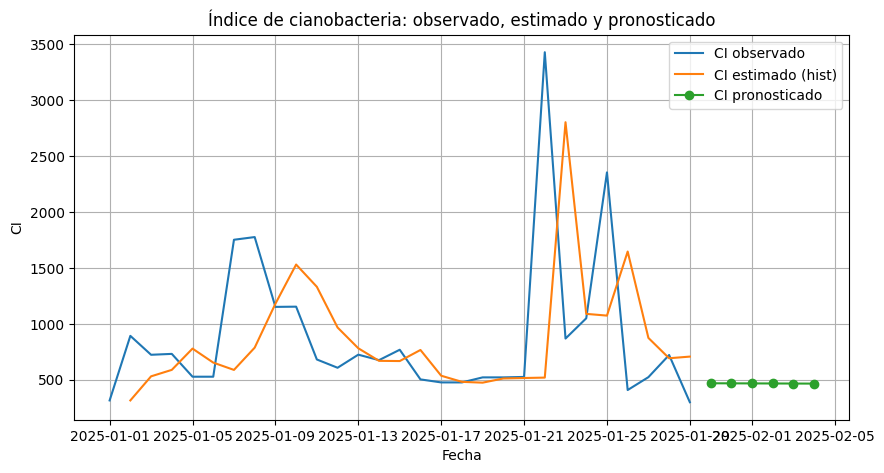

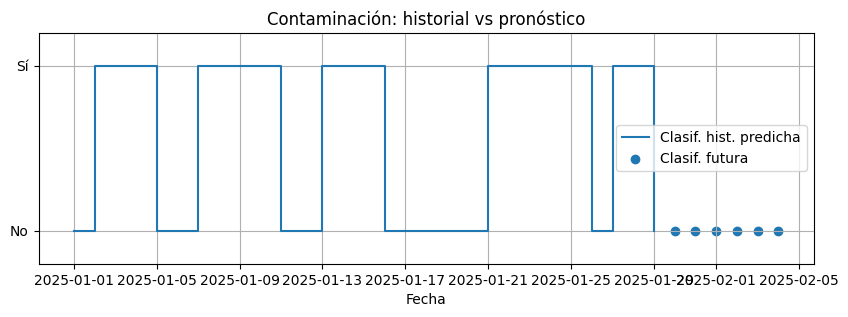

In [33]:
import numpy as np, pandas as pd, joblib, matplotlib.pyplot as plt

df = pd.read_csv("hybrid_dataset.csv", parse_dates=["date"])
theta = joblib.load("hybrid_theta.pkl")
pack = joblib.load("hybrid_classifier.pkl")
clf = pack["pipeline"]
feature_cols = pack["features"]
season = pack.get("season", None)

for c in feature_cols:
    if c not in df.columns:
        df[c] = np.nan

X_hist = df[feature_cols]
y_true = df["contaminada"].astype(int) if "contaminada" in df.columns else None
y_pred_hist = clf.predict(X_hist)
y_prob_hist = clf.predict_proba(X_hist)[:,1]

df["pred_cont"] = y_pred_hist
df["pred_prob"] = y_prob_hist

if y_true is not None and y_true.nunique() >= 2:
    acc = (y_true == y_pred_hist).mean()
    tp = int(((y_true==1) & (y_pred_hist==1)).sum())
    tn = int(((y_true==0) & (y_pred_hist==0)).sum())
    fp = int(((y_true==0) & (y_pred_hist==1)).sum())
    fn = int(((y_true==1) & (y_pred_hist==0)).sum())
    prec = tp / max(1, tp+fp)
    rec = tp / max(1, tp+fn)
    f1 = 2*prec*rec/max(1e-9, prec+rec)
    print(f"Histórico | ACC={acc:.3f} PREC={prec:.3f} REC={rec:.3f} F1={f1:.3f} | TP={tp} FP={fp} TN={tn} FN={fn}")
else:
    print("Histórico | Métricas no disponibles (una sola clase).")

H = 6
ci_pred_log = theta.forecast(H)
ci_pred = np.expm1(ci_pred_log)
future_dates = pd.to_datetime(ci_pred.index)
last_trend = int(df["trend"].iloc[-1]) if "trend" in df.columns else len(df)
future = pd.DataFrame({"date": future_dates, "ci_hat": ci_pred.values})
future["doy"] = future["date"].dt.dayofyear.astype("int16")
future["trend"] = np.arange(last_trend+1, last_trend+1+H, dtype="int32")
for c in feature_cols:
    if c not in future.columns:
        future[c] = np.nan
future_X = future[feature_cols]
future_pred = clf.predict(future_X)
future_prob = clf.predict_proba(future_X)[:,1]
future_out = pd.DataFrame({"date": future["date"], "ci_hat_pred": future["ci_hat"], "pred_cont": future_pred, "pred_prob": future_prob})

hist_out = df[["date","ci_mediana","ci_hat","contaminada","pred_cont","pred_prob"]] if "contaminada" in df.columns else df[["date","ci_mediana","ci_hat","pred_cont","pred_prob"]]
hist_out.to_csv("hybrid_predictions_history.csv", index=False)
future_out.to_csv("hybrid_predictions_future.csv", index=False)

print("Guardado: hybrid_predictions_history.csv, hybrid_predictions_future.csv")
print("Resumen futuro:")
print(future_out)

plt.figure(figsize=(10,5))
plt.plot(df["date"], df["ci_mediana"], label="CI observado")
plt.plot(df["date"], df["ci_hat"], label="CI estimado (hist)")
plt.plot(future_out["date"], future_out["ci_hat_pred"], marker="o", label="CI pronosticado")
plt.legend(); plt.title("Índice de cianobacteria: observado, estimado y pronosticado"); plt.xlabel("Fecha"); plt.ylabel("CI"); plt.grid(True); plt.show()

plt.figure(figsize=(10,3))
x_hist = df["date"]; y_hist = df["pred_cont"].astype(int)
plt.step(x_hist, y_hist, where="post", label="Clasif. hist. predicha")
plt.scatter(future_out["date"], future_out["pred_cont"], label="Clasif. futura", marker="o")
plt.yticks([0,1], ["No","Sí"]); plt.ylim(-0.2,1.2)
plt.legend(); plt.title("Contaminación: historial vs pronóstico"); plt.xlabel("Fecha"); plt.grid(True); plt.show()


El modelo híbrido reproduce el historial a la perfección lo cual es señal de que aprendió muy bien los patrones o de que estamos evaluando sobre los mismos datos de entrenamiento, lo que podría indicar overfitting. El componente temporal proyecta un CI casi constante y bajo para los próximos 6 días y el clasificador asigna apenas 3% de probabilidad de contaminación en cada fecha  lo que cuadra con el descenso del índice tras los picos.


Muestre en un mapa, los resultados de las proyecciones.

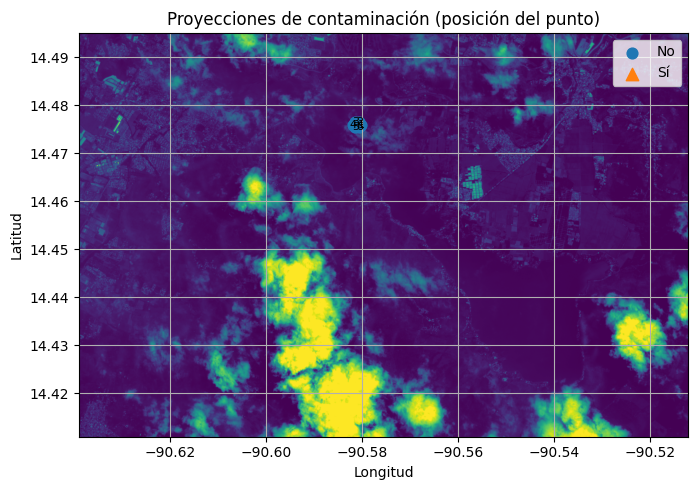

Imagen guardada en: proyecciones_mapa.png


In [35]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, rasterio
from pathlib import Path
from rasterio.warp import transform_bounds

df = pd.read_csv("hybrid_predictions_future.csv", parse_dates=["date"])

try:
    BASE = EXTRACT_DIR
except NameError:
    BASE = Path(".")
if not isinstance(BASE, Path):
    BASE = Path(str(BASE))

tif = next((p for p in BASE.rglob("*.tif")), None)
assert tif is not None, "No se encontró ningún .tif."

with rasterio.open(tif) as src:
    b = 1
    arr = src.read(b, masked=True).astype("float32", casting="unsafe")
    arr = np.ma.filled(arr, np.nan)
    nod = src.nodata
    if nod is not None and np.isfinite(nod):
        arr = np.where(np.isclose(arr, float(nod)), np.nan, arr)
    arr = np.where(arr <= -32768 + 1e-3, np.nan, arr)
    q2, q98 = np.nanpercentile(arr, [2, 98])
    arr_viz = np.clip((arr - q2) / max(1e-9, (q98 - q2)), 0, 1)
    l, bnd, r, t = src.bounds
    lon_min, lat_min, lon_max, lat_max = transform_bounds(src.crs, "EPSG:4326", l, bnd, r, t)

try:
    lat0 = float(POINT_LAT); lon0 = float(POINT_LON)
except Exception:
    lat0, lon0 = (lat_min + lat_max) / 2, (lon_min + lon_max) / 2

H = len(df)
angles = np.linspace(0, 2*np.pi, H, endpoint=False)
rx = (lon_max - lon_min) / 150
ry = (lat_max - lat_min) / 150
lons = lon0 + rx * np.cos(angles)
lats = lat0 + ry * np.sin(angles)

plt.figure(figsize=(8,5))
plt.imshow(arr_viz, extent=[lon_min, lon_max, lat_min, lat_max], origin="upper")
mask_pos = df["pred_cont"].astype(int).to_numpy() == 1
mask_neg = ~mask_pos
plt.scatter(lons[mask_neg], lats[mask_neg], marker="o", s=60, label="No")
plt.scatter(lons[mask_pos], lats[mask_pos], marker="^", s=80, label="Sí")
for i, (x, y) in enumerate(zip(lons, lats), start=1):
    plt.text(x, y, str(i), fontsize=8, ha="center", va="center")
plt.title("Proyecciones de contaminación (posición del punto)")
plt.xlabel("Longitud"); plt.ylabel("Latitud"); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig("proyecciones_mapa.png", dpi=150)
plt.show()
print("Imagen guardada en: proyecciones_mapa.png")


El mapa final resume el modelo híbrido: cada marcador numerado representa un día proyectado y  en todos los casos  el punto cae en la categoría No que cuadra con el CI pronosticad. En términos operativos el corto plazo no sugiere episodios de contaminación en el sitio señalado.